# Modèle de regression

# Chargement et mise en forme des données

In [376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from math import log,sqrt,exp

import random
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, LassoLarsCV
from itertools import cycle

In [377]:
PATH = '../requetes/'
data = pd.read_csv(PATH+'requetes1.csv')
data.head()

,avatar_id,city,date,language,mobile,hotel_id,price,stock,group,brand,parking,pool,children_policy
0,3530,paris,40,dutch,0,467,244,214,Accar Hotels,Safitel,0,0,0
1,3530,paris,40,dutch,0,708,147,102,Yin Yang,Ardisson,1,0,0
2,3530,paris,40,dutch,0,853,147,110,Chillton Worldwide,Tripletree,1,0,0
3,3530,paris,40,dutch,0,207,154,108,Boss Western,J.Halliday Inn,0,0,1
4,3530,paris,40,dutch,0,415,116,83,Boss Western,Boss Western,1,0,0


In [378]:
# transformation des données en fonction de celles qu'on a identifié dans le notebook d'analyse des données de requetes
data["price_mod"]=data["price"].map(lambda x: log(x))
data["stock_mod"]=data["stock"].map(lambda x: sqrt(x))
data_mod = data.drop(["price","stock"],axis=1)

Pour la mise en forme des données, je décide d'ajouter une colonne order_request, comme dans le set de test. On verra bien ce que ça donne. 

Les lignes qui sont issues du résultat de la même requête se caractérisent par un ID d'utilisateur constant, une ville et une date constantes. 

In [379]:
order = np.zeros(len(data_mod.index),dtype=int)

# référence pour le début = la première ligne du dataframe
ref_line = 0
order[0] = 1

for line in range(0,len(data_mod.index)):
    request_line = data_mod.loc[line,['avatar_id','city','date']].to_numpy()
    request_ref_line = data_mod.loc[ref_line,['avatar_id','city','date']].to_numpy() 
    if (request_line == request_ref_line).all() :
        order[line] = order[ref_line]
    else : 
        order[line] = order[ref_line]+1
        ref_line = line

In [380]:
data_mod['order_requests'] = order
data_mod.head()

,avatar_id,city,date,language,mobile,hotel_id,group,brand,parking,pool,children_policy,price_mod,stock_mod,order_requests
0,3530,paris,40,dutch,0,467,Accar Hotels,Safitel,0,0,0,5.497168,14.628739,1
1,3530,paris,40,dutch,0,708,Yin Yang,Ardisson,1,0,0,4.990433,10.099505,1
2,3530,paris,40,dutch,0,853,Chillton Worldwide,Tripletree,1,0,0,4.990433,10.488088,1
3,3530,paris,40,dutch,0,207,Boss Western,J.Halliday Inn,0,0,1,5.036953,10.392305,1
4,3530,paris,40,dutch,0,415,Boss Western,Boss Western,1,0,0,4.753590,9.110434,1


On change les types des variables.

In [381]:
# définition des variables quntitatives et qualitatives : 
var_quant = ["date","stock_mod"]
var_quali = ["city","language", "mobile","group","brand","parking","pool","children_policy"]

for var in var_quali :
    data_mod[var]=pd.Categorical(data_mod[var],ordered=False)

data_mod.dtypes

avatar_id             int64
city               category
date                  int64
language           category
mobile             category
hotel_id              int64
group              category
brand              category
parking            category
pool               category
children_policy    category
price_mod           float64
stock_mod           float64
order_requests        int64
dtype: object

In [382]:
# Renormalisation des variables quantitatives : 
scalerX = StandardScaler()  
scalerX.fit(data_mod[var_quant])  
X_quant = pd.DataFrame(scalerX.transform(data_mod[var_quant]),columns=var_quant)

# Renormalisation de l'output :
Y = data_mod["price_mod"].to_numpy()
scalerY = StandardScaler()  
scalerY.fit(Y.reshape(-1,1))
Y_norm = scalerY.transform(Y.reshape(-1,1)).flatten()

RQ : quand on utilise le set de test, ne pas oublier d'effectuer les mêmes modifications sur le tableau de données (log,sqrt,renormalisation)

In [383]:
# transformation des variables qualitatives en dummy variables
X_dum = pd.get_dummies(data_mod[var_quali])
X = pd.concat([data_mod[['order_requests','avatar_id','hotel_id']],X_quant,X_dum],axis=1)

Selon le modèle il faut transformer les variables qualitatives en dummy variables => s'en souvenir !

# Préparation des données de test 

In [384]:
# chargement des données de test : 
data_test = pd.read_csv('../Test_set_analysis/test_set_complet.csv')
data_test.dtypes

order_requests      int64
city               object
date                int64
language           object
mobile              int64
avatar_id           int64
hotel_id            int64
stock               int64
group              object
brand              object
parking             int64
pool                int64
children_policy     int64
dtype: object

In [385]:
# apply the same transformations on the test set : 
# qualitative variables to categorical 
for var in var_quali :
    data_test[var]=pd.Categorical(data_test[var],ordered=False)
    
# recentrer et renormaliser les variables : 
data_test["stock_mod"]=data_test["stock"].map(lambda x: sqrt(x))
data_test_mod = data_test.drop(["stock"],axis=1)
scaler_test = StandardScaler()  
scaler_test.fit(data_test_mod[var_quant])
X_test_quant = pd.DataFrame(scaler_test.transform(data_test_mod[var_quant]),columns=var_quant)

# transformation des variables qualitatives en dummy variables
X_test_dum = pd.get_dummies(data_test_mod[var_quali])
X_test = pd.concat([data_test_mod[['order_requests']],X_test_quant,X_test_dum],axis=1)

# Séparation des données en échantillon d'entrainement et validation

In [386]:
# 20% des avatar_ID seront dans le test set et 80% dans le train set
alpha = 0.8
n = len(ind_user)
ind_user = np.unique(data_mod['avatar_id'])
random.shuffle(ind_user)
ind_train = ind_user[:int(alpha*n)]
ind_vali = ind_user[int(alpha*n):]

# sélection des lignes correspondantes dans le dataframe 
X_train = X.loc[X['avatar_id'].isin(ind_train)]
X_vali = X.loc[X['avatar_id'].isin(ind_vali)]

In [387]:
# séparation de la colonne des outputs en training et validation : 
indX_train = X.index[X['avatar_id'].isin(ind_train)]
Y_train = Y_norm[indX_train]
indX_vali = X.index[X['avatar_id'].isin(ind_vali)]
Y_vali = Y_norm[indX_vali]

In [388]:
# suppression des ID maintenant qu'on en a plus besoin
X_train.drop(['avatar_id','hotel_id'],axis=1,inplace=True)
X_vali.drop(['avatar_id','hotel_id'],axis=1,inplace=True)

<ipython-input-388-06a2bef623d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['avatar_id','hotel_id'],axis=1,inplace=True)
<ipython-input-388-06a2bef623d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_vali.drop(['avatar_id','hotel_id'],axis=1,inplace=True)


# Construction du modèle et analyse des résultats

In [389]:
regLasso = linear_model.Lasso(alpha=0)
regLasso.fit(X_train,Y_train)
prev=regLasso.predict(X_vali)
print("MSE=",mean_squared_error(Y_vali,prev)) # sur les résultats normalisés

<ipython-input-389-47be29821655>:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regLasso.fit(X_train,Y_train)
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


MSE= 0.08917407737260181


/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.797e+03, tolerance: 8.665e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [390]:
# MSE sur les données dénormalisées et détransformées : 
prev_denorm = scalerY.inverse_transform(prev.reshape(-1,1))
prev_detransfo = np.exp(prev_denorm)
Y_vali_denorm = scalerY.inverse_transform(Y_vali.reshape(-1,1))
Y_vali_detransfo = np.exp(Y_vali_denorm)
print("MSE sur les résultats dénormalisés =",mean_squared_error(Y_vali_detransfo,prev_detransfo))
print("MAE sur les résultats dénormalisés =",mean_absolute_error(Y_vali_detransfo,prev_detransfo))

MSE sur les résultats dénormalisés = 496.2373700833351
MAE sur les résultats dénormalisés = 14.606736625291477


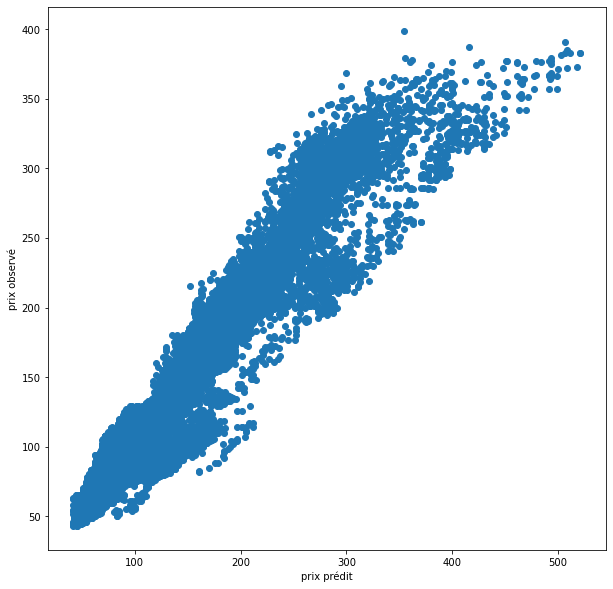

In [395]:
plt.figure(figsize=(10,10))
plt.plot(Y_vali_detransfo,prev_detransfo,"o")
plt.xlabel("prix prédit")
plt.ylabel("prix observé")
plt.show()

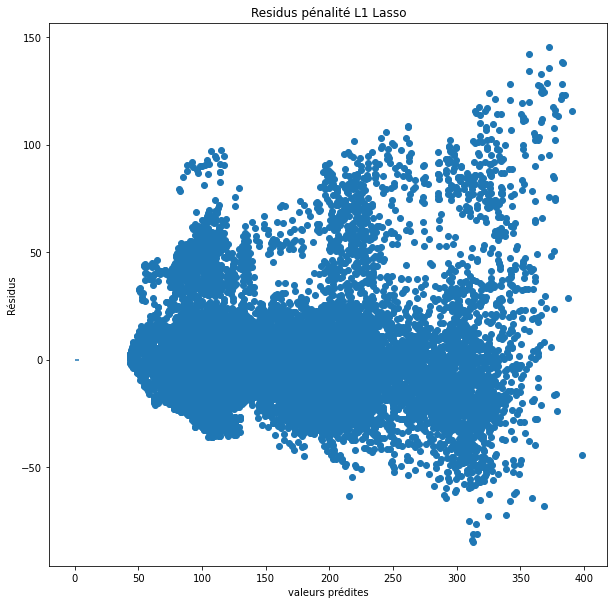

In [397]:
plt.figure(figsize=(10,10))
plt.plot(prev_detransfo,Y_vali_detransfo-prev_detransfo,"o")
plt.xlabel(u"valeurs prédites")
plt.ylabel(u"Résidus")
plt.title("Residus pénalité L1 Lasso") 
plt.hlines(0,0,3)
plt.show()

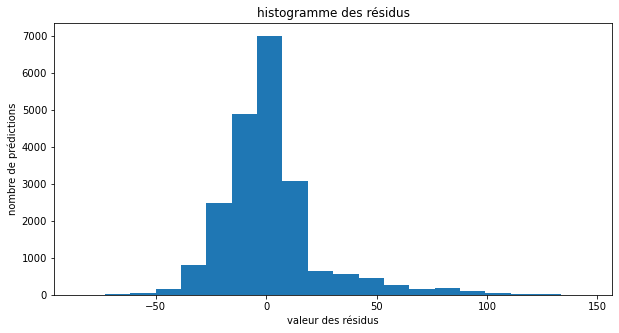

In [404]:
plt.figure(figsize=(10,5))
plt.hist(Y_vali_detransfo-prev_detransfo,bins=20)
plt.title('histogramme des résidus')
plt.xlabel('valeur des résidus')
plt.ylabel('nombre de prédictions')
plt.show()

In [394]:
# On ré-entraine l'algo sur tout le jeu de données et on prédit le set de test : 
regLasso_complet = linear_model.Lasso(alpha=0)
regLasso_complet.fit(X_train,Y_train)
prev = regLasso_complet.predict(X_test)
prev = pd.DataFrame(np.exp(scalerY.inverse_transform(prev.reshape(-1,1))))
prev.to_csv("../predictions/prediction_regLasso.csv")

<ipython-input-394-67390f15db01>:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  regLasso_complet.fit(X_train,Y_train)
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/julie/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.797e+03, tolerance: 8.665e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


# Continuer avec la sélection de variables